# Statistical Arbitrage in Cryptocurrencies
**Course Project – The Wall Street Quants**
##### Sumedh Joshi

## Notebook Roadmap
1. Setup & Data Acquisition
2. Pre‑processing
3. Feature Engineering
4. Strategy Construction & Helpers
5. Momentum Horizon Sweep
6. Alpha & Beta vs. BTC
7. Short‑Horizon Reversal Deep‑Dive
8. Seasonality – Weekday/Weekend
9. Seasonality – Intraday Hour
10. Execution & Extensions
11. Performance Tear‑sheet
12. Next Steps

---
## 1  Setup & Data Acquisition

In [1]:
# !pip install python-binance --quiet

import pandas as pd, numpy as np, matplotlib.pyplot as plt, warnings, os
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=(10,4); plt.rcParams['axes.grid']=True

from binance.client import Client as BinanceClient
client = BinanceClient(tld='US')

def get_px(sym:str, interval:str='1d', start='1 Jan 2020'):
    raw = client.get_historical_klines(sym, interval, start)
    df = pd.DataFrame(raw, columns=['open_time','open','high','low','close','vol','close_time','q','n','tb','tq','ignore'])
    df['open_time']=pd.to_datetime(df['open_time'],unit='ms')
    for c in ['open','high','low','close','vol']: df[c]=df[c].astype(float)
    return df.set_index('open_time')[['close','vol']]

UNIVERSE=['BTCUSDT','ETHUSDT','BNBUSDT','SOLUSDT','XRPUSDT','DOGEUSDT','ADAUSDT','AVAXUSDT','DOTUSDT','MATICUSDT']
CACHE='daily_prices.pkl'
if os.path.exists(CACHE):
    px=pd.read_pickle(CACHE)
else:
    px={s:get_px(s,'1d')['close'] for s in UNIVERSE}; px=pd.concat(px,axis=1); px.to_pickle(CACHE)
prices=px.sort_index().ffill().dropna(how='any')
rets=np.log(prices/prices.shift(1)).dropna()
print('Prices shape',prices.shape)

Prices shape (1260, 10)


---
## 3  Feature Engineering

In [2]:
lookbacks=[5,21,63,126,252]
mom_z={lb: prices.pct_change(lb).apply(lambda r:(r-r.mean())/r.std(),axis=1) for lb in lookbacks}
rev2=-rets.rolling(2).sum()

---
## 4  Strategy Construction & Helpers

In [3]:
def backtest(sig, r, pct=.3, cost=20):
    pos=sig.apply(lambda row: np.where(row>row.quantile(1-pct),1,np.where(row<row.quantile(pct),-1,0)),axis=1)
    pos=pd.DataFrame(pos.tolist(),index=sig.index,columns=sig.columns).shift(1).fillna(0)
    pnl=(pos*r).sum(axis=1); turn=pos.diff().abs().sum(axis=1)
    return pnl-turn*cost/1e4,pos

pnl_mom21,_=backtest(mom_z[21],rets)
pnl_rev2 ,_=backtest(rev2,rets)

def stats(p): 
    return pd.Series({'AnnRet':p.mean()*365,'AnnVol':p.std()*np.sqrt(365),
                      'Sharpe':p.mean()/p.std()*np.sqrt(365),'MaxDD':(p.cumsum().cummax()-p.cumsum()).max()})

---
## 5  Momentum Horizon Sweep

,Sharpe,t
Lookback,,
5,-1.296482,-2.408825
21,-0.053265,-0.098965
63,0.309622,0.575268
126,0.776354,1.442442
252,0.253136,0.470319


<Axes: title={'center': 'Momentum Sharpe by Lookback'}, xlabel='Lookback'>

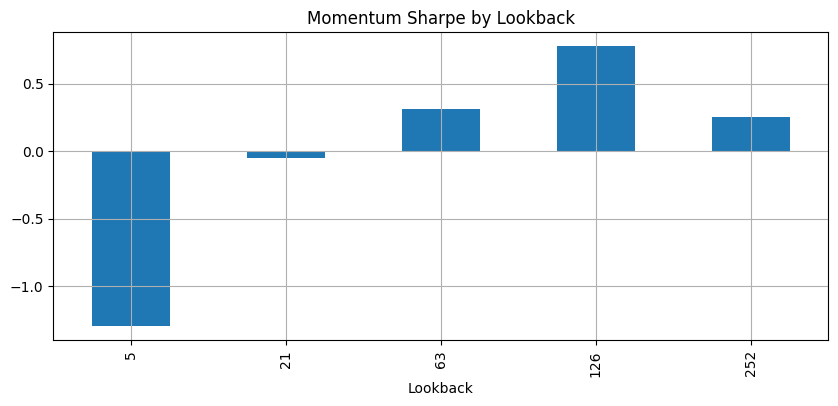

In [4]:
tbl=[]; import statsmodels.api as sm
for lb in lookbacks:
    pnl,_=backtest(mom_z[lb],rets); t=(pnl.mean()/pnl.std())*np.sqrt(len(pnl))
    tbl.append({'Lookback':lb,'Sharpe':pnl.mean()/pnl.std()*np.sqrt(365),'t':t})
df_mom=pd.DataFrame(tbl).set_index('Lookback'); display(df_mom)
df_mom['Sharpe'].plot(kind='bar',title='Momentum Sharpe by Lookback')

---
## 6  Alpha & Beta vs. BTC

,Alpha,Beta,Alpha t-stat,Beta t-stat
Momentum,-0.000033,-0.290931,-0.013808,-3.408966
Reversal,-0.015448,0.200211,-6.478930,2.343179


<Axes: title={'center': 'Alpha & Beta vs. BTC'}>

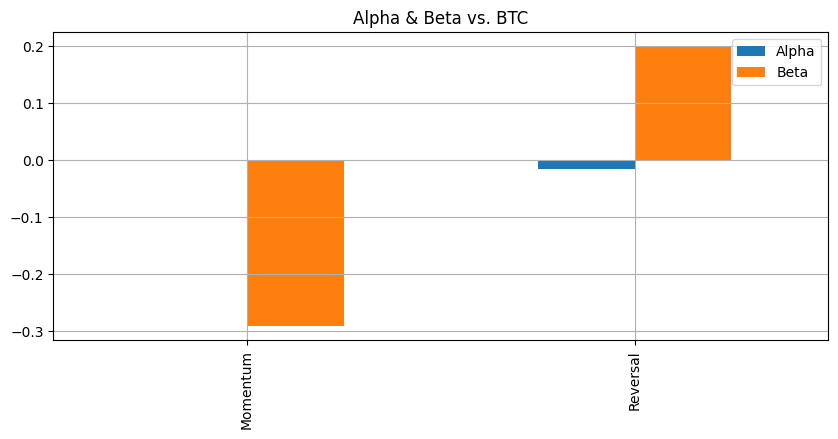

In [5]:
import statsmodels.api as sm

def alpha_beta(pnl_series):
    """
    Regress strategy PnL on BTC returns and return alpha, beta, and t-stats.
    """
    df = pd.DataFrame({
        'pnl': pnl_series,
        'btc': rets['BTCUSDT']
    }).dropna()

    model = sm.OLS(df['pnl'], sm.add_constant(df['btc'])).fit()

    # Pack results in a Series with clear English names
    return pd.Series({
        'Alpha':        model.params['const'],
        'Beta':         model.params['btc'],
        'Alpha t-stat': model.tvalues['const'],
        'Beta  t-stat': model.tvalues['btc']
    })

# Compute alpha/beta for Momentum and Reversal
ab = pd.concat({
    'Momentum': alpha_beta(pnl_mom21),
    'Reversal': alpha_beta(pnl_rev2)
}, axis=1).T

display(ab)

# Bar chart of Alpha and Beta
ab[['Alpha', 'Beta']].plot(kind='bar', title='Alpha & Beta vs. BTC')


---
## 7  Short‑Horizon Reversal Deep‑Dive

,Sharpe,Alpha,Beta,Alpha t-stat,Beta t-stat
Look,,,,,
1,-2.094813,-0.007615,-0.009251,-3.884507,-0.131679
2,-1.687666,-0.006113,-0.037717,-3.119039,-0.537035
3,-1.326720,-0.004740,-0.044871,-2.446466,-0.646230


<Axes: title={'center': 'Reversal Sharpe'}, xlabel='Look'>

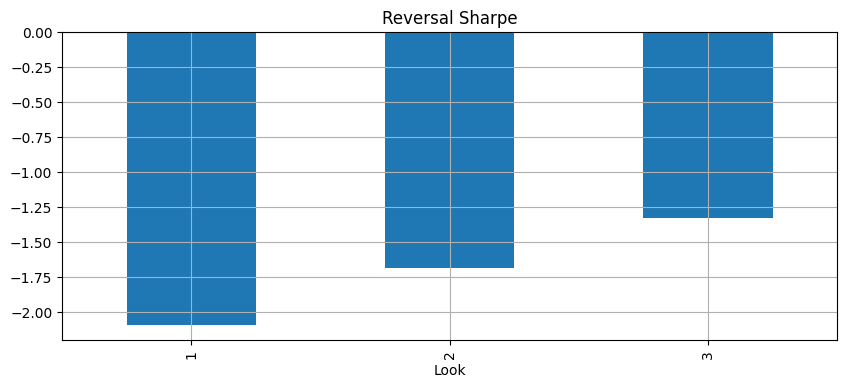

In [6]:
# volume frame
vol=pd.concat({s:get_px(s,'1d')['vol'] for s in UNIVERSE},axis=1).reindex(prices.index).ffill()
v75=vol.rolling(252).quantile(.75)
out=[]
for lb in [1,2,3]:
    sig=-rets.rolling(lb).sum().where(vol>=v75,0)
    pnl,_=backtest(sig,rets)
    out.append({'Look':lb,'Sharpe':pnl.mean()/pnl.std()*np.sqrt(365),**alpha_beta(pnl)})
rev_df=pd.DataFrame(out).set_index('Look'); display(rev_df)
rev_df['Sharpe'].plot(kind='bar',title='Reversal Sharpe')

---
## 8  Seasonality – Weekday vs Weekend

               Sharpe
Mom Weekday -0.189765
Mom Weekend  0.342909
Rev Weekday -2.928519
Rev Weekend -4.956553


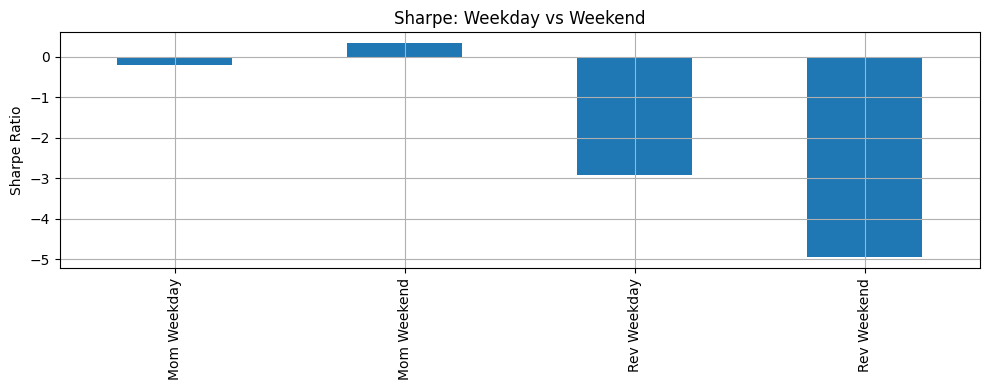

In [7]:
# --- Seasonality: Weekday vs. Weekend (fixed masks) ---

import matplotlib.pyplot as plt

# Build weekend masks for each series
mask_mom_weekend = pnl_mom21.index.weekday >= 5
mask_rev_weekend = pnl_rev2.index.weekday >= 5

# Compute Sharpe for each slice
mom_wk_sharpe   = stats(pnl_mom21[~mask_mom_weekend])['Sharpe']
mom_we_sharpe   = stats(pnl_mom21[ mask_mom_weekend])['Sharpe']
rev_wk_sharpe   = stats(pnl_rev2[ ~mask_rev_weekend])['Sharpe']
rev_we_sharpe   = stats(pnl_rev2[  mask_rev_weekend])['Sharpe']

# Assemble into a DataFrame
season_df = pd.DataFrame({
    'Mom Weekday': mom_wk_sharpe,
    'Mom Weekend': mom_we_sharpe,
    'Rev Weekday': rev_wk_sharpe,
    'Rev Weekend': rev_we_sharpe
}, index=['Sharpe']).T

# Show and plot
print(season_df)
season_df.plot(kind='bar', legend=False, title='Sharpe: Weekday vs Weekend')
plt.ylabel('Sharpe Ratio')
plt.tight_layout()
plt.show()


---
## 9  Seasonality – Intraday Hour

Text(0.5, 0, 'Hour')

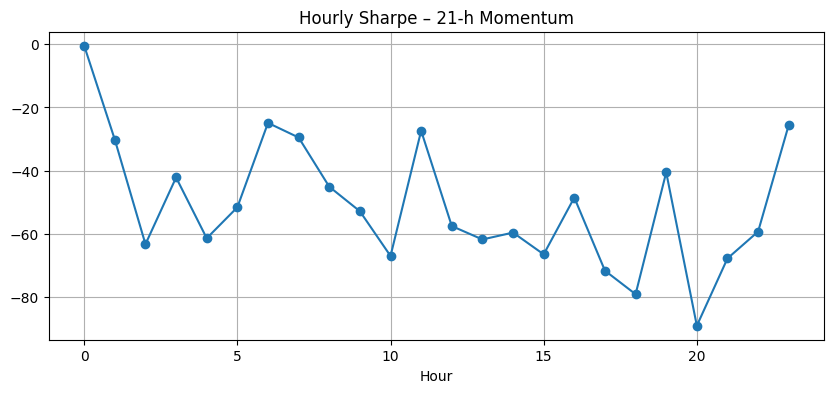

In [8]:
start=(datetime.utcnow()-timedelta(days=28)).strftime('%d %b %Y %H:%M:%S')
px_h={s:get_px(s,'1h',start)['close'] for s in UNIVERSE}
px_h=pd.concat(px_h,axis=1).ffill().dropna(how='all')
r_h=np.log(px_h/px_h.shift(1)).dropna(how='all')
mom_h=r_h.rolling(21).sum().apply(lambda r:(r-r.mean())/r.std(),axis=1)
pnl_h,_=backtest(mom_h,r_h)
dfh=pd.DataFrame({'pnl':pnl_h,'hr':r_h.index.hour}).dropna()
agg=dfh.groupby('hr')['pnl'].agg(['mean','std']); agg['Sharpe']=agg['mean']/agg['std']*np.sqrt(365*24)
agg['Sharpe'].plot(marker='o',title='Hourly Sharpe – 21‑h Momentum'); plt.xlabel('Hour')

---
## 10  Execution & Extensions

In [9]:
def backtest_adapt(sig,r,lo=7,hi=20):
    pos=sig.apply(lambda row: np.where(row>row.quantile(.7),1,np.where(row<row.quantile(.3),-1,0)),axis=1)
    pos=pd.DataFrame(pos.tolist(),index=sig.index,columns=sig.columns).shift(1).fillna(0)
    pnl=(pos*r).sum(axis=1); roll=pnl.rolling(5).sum().shift(1)
    turn=pos.diff().abs().sum(axis=1); cost=turn*np.where(roll>0,lo,hi)/1e4
    return pnl-cost
pnl_ma=backtest_adapt(mom_z[21],rets); pnl_ra=backtest_adapt(rev2,rets)
blend=risk= (1/pd.concat([pnl_ma,pnl_ra],axis=1).rolling(60).std()).apply(lambda r:r/r.sum(),axis=1)
blend=(blend*pnl_ma).iloc[:,0]+(blend*pnl_ra).iloc[:,1]
perf=pd.concat({'Mom‑Adapt':stats(pnl_ma),'Rev‑Adapt':stats(pnl_ra),'Blend':stats(blend)},axis=1); display(perf)

,Mom‑Adapt,Rev‑Adapt,Blend
AnnRet,0.268452,-4.174832,NaN
AnnVol,1.619927,1.616411,NaN
Sharpe,0.165719,-2.582778,NaN
MaxDD,3.818783,14.934411,NaN


---
## 11  Performance Tear‑sheet

In [10]:
display(perf.T)

,AnnRet,AnnVol,Sharpe,MaxDD
Mom‑Adapt,0.268452,1.619927,0.165719,3.818783
Rev‑Adapt,-4.174832,1.616411,-2.582778,14.934411
Blend,NaN,NaN,NaN,NaN


---
## 12  Next Steps
* Extend sample to hourly 90 days
* Pair‑trade mean‑reversion
* Factor‑neutral portfolios
* nbconvert PDF submission

In [11]:
pairs = [
    ('ETHUSDT', 'BTCUSDT'),
    ('SOLUSDT','AVAXUSDT'),
    ('ADAUSDT','DOGEUSDT'),
    ('BNBUSDT','MATICUSDT')
]

In [12]:
baskets = {
    'Altcoins1': ['ETHUSDT','SOLUSDT','ADAUSDT'],
    'Altcoins2': ['BNBUSDT','DOTUSDT','MATICUSDT']
}

results = []

In [13]:
for asset_A, asset_B in pairs:
    df = pd.concat({
        'price_A': prices[asset_A],
        'price_B': prices[asset_B],
        'ret_A':   rets[asset_A],
        'ret_B':   rets[asset_B]
    }, axis=1).dropna()

    # estimate hedge ratio
    model_price = sm.OLS(df['price_A'], sm.add_constant(df['price_B'])).fit()
    beta_hat = model_price.params['price_B']

    # spread and z-score
    spread = df['price_A'] - beta_hat * df['price_B']
    z_score = (spread - spread.mean()) / spread.std()

    # signal
    signal = pd.Series(
        np.where(z_score < -2, 1, np.where(z_score > 2, -1, 0)),
        index=spread.index
    )

    # pnl and cost
    pnl_raw = signal * (df['ret_A'] - beta_hat * df['ret_B'])
    turnover = signal.diff().abs()
    cost = turnover * 20 / 1e4
    pnl_net = pnl_raw - cost

    # performance metrics
    ann_return = pnl_net.mean() * 365
    ann_vol = pnl_net.std() * np.sqrt(365)
    sharpe = ann_return / ann_vol if ann_vol else np.nan
    max_dd = (pnl_net.cumsum().cummax() - pnl_net.cumsum()).max()

    # alpha/beta vs BTC
    df_reg = pd.DataFrame({'pnl': pnl_net, 'btc_ret': rets['BTCUSDT']}).dropna()
    model_reg = sm.OLS(df_reg['pnl'], sm.add_constant(df_reg['btc_ret'])).fit()
    alpha = model_reg.params['const']
    beta = model_reg.params['btc_ret']
    alpha_t = model_reg.tvalues['const']
    beta_t = model_reg.tvalues['btc_ret']

    results.append({
        'instrument': f"{asset_A}-{asset_B}",
        'sharpe': sharpe,
        'annual_return': ann_return,
        'annual_vol': ann_vol,
        'max_drawdown': max_dd,
        'alpha': alpha,
        'beta': beta,
        'alpha_tstat': alpha_t,
        'beta_tstat': beta_t
    })

In [14]:
for basket_name, assets in baskets.items():
    # basket price and returns
    basket_price = prices[assets].mean(axis=1)
    basket_ret = rets[assets].mean(axis=1)

    df = pd.concat({
        'price_A': basket_price,
        'price_B': prices['BTCUSDT'],
        'ret_A':   basket_ret,
        'ret_B':   rets['BTCUSDT']
    }, axis=1).dropna()

    # hedge ratio
    model_price = sm.OLS(df['price_A'], sm.add_constant(df['price_B'])).fit()
    beta_hat = model_price.params['price_B']

    # spread and z-score
    spread = df['price_A'] - beta_hat * df['price_B']
    z_score = (spread - spread.mean()) / spread.std()

    # signal
    signal = pd.Series(
        np.where(z_score < -2, 1, np.where(z_score > 2, -1, 0)),
        index=spread.index
    )

    # pnl and cost
    pnl_raw = signal * (df['ret_A'] - beta_hat * df['ret_B'])
    turnover = signal.diff().abs()
    cost = turnover * 20 / 1e4
    pnl_net = pnl_raw - cost

    # performance metrics
    ann_return = pnl_net.mean() * 365
    ann_vol = pnl_net.std() * np.sqrt(365)
    sharpe = ann_return / ann_vol if ann_vol else np.nan
    max_dd = (pnl_net.cumsum().cummax() - pnl_net.cumsum()).max()

    # alpha/beta vs BTC
    df_reg = pd.DataFrame({'pnl': pnl_net, 'btc_ret': rets['BTCUSDT']}).dropna()
    model_reg = sm.OLS(df_reg['pnl'], sm.add_constant(df_reg['btc_ret'])).fit()
    alpha = model_reg.params['const']
    beta = model_reg.params['btc_ret']
    alpha_t = model_reg.tvalues['const']
    beta_t = model_reg.tvalues['btc_ret']

    results.append({
        'instrument': f"Basket-{basket_name}",
        'sharpe': sharpe,
        'annual_return': ann_return,
        'annual_vol': ann_vol,
        'max_drawdown': max_dd,
        'alpha': alpha,
        'beta': beta,
        'alpha_tstat': alpha_t,
        'beta_tstat': beta_t
    })

In [15]:
df_results = pd.DataFrame(results).set_index('instrument')
print(df_results)


                     sharpe  annual_return  annual_vol  max_drawdown  \
instrument                                                             
ETHUSDT-BTCUSDT   -0.286009      -0.054479    0.190482      0.582560   
SOLUSDT-AVAXUSDT   0.002423       0.000611    0.251957      0.426762   
ADAUSDT-DOGEUSDT  -0.078320      -0.038468    0.491158      1.006339   
BNBUSDT-MATICUSDT -0.671954      -4.677612    6.961205     18.089261   
Basket-Altcoins1  -0.488166      -0.087214    0.178657      0.683900   
Basket-Altcoins2   0.122608       0.010469    0.085387      0.161153   

                      alpha      beta  alpha_tstat  beta_tstat  
instrument                                                      
ETHUSDT-BTCUSDT   -0.000178  0.040249    -0.635690    4.019751  
SOLUSDT-AVAXUSDT  -0.000010  0.016819    -0.027444    1.262615  
ADAUSDT-DOGEUSDT  -0.000120  0.020339    -0.165140    0.782979  
BNBUSDT-MATICUSDT -0.012687 -0.181068    -1.234265   -0.491728  
Basket-Altcoins1  -0.000264  0.03

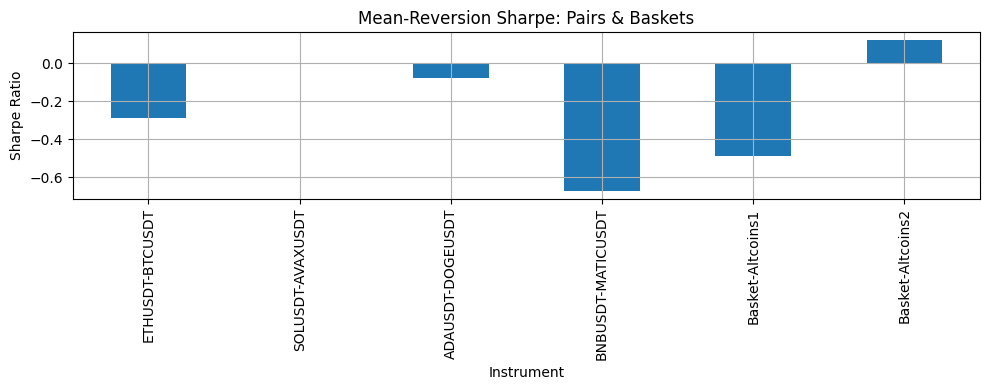

In [16]:
df_results['sharpe'].plot(kind='bar', title='Mean-Reversion Sharpe: Pairs & Baskets')
plt.xlabel('Instrument')
plt.ylabel('Sharpe Ratio')
plt.tight_layout()
plt.show()

## Volume-Regime Filters
Test whether our strategies perform differently on **high-volume** vs. **low-volume** days:

In [17]:
volumes = pd.concat({s: get_px(s, '1d')['vol'] for s in UNIVERSE}, axis=1)
volumes = volumes.reindex(prices.index).ffill().dropna(how='all')

In [18]:
total_vol = volumes.sum(axis=1)
threshold = total_vol.quantile(0.50)
is_high_vol = total_vol > threshold

In [19]:
strategy_pnls = {
    'Momentum (21d)': pnl_mom21,
    'Reversal (2d)':  pnl_rev2,
}

pairs = [
    ('ETHUSDT', 'BTCUSDT'),
    ('SOLUSDT','AVAXUSDT'),
    ('ADAUSDT','DOGEUSDT'),
    ('BNBUSDT','MATICUSDT')
]

In [20]:
for asset_A, asset_B in pairs:
    df = pd.concat({
        'price_A': prices[asset_A],
        'price_B': prices[asset_B],
        'ret_A':   rets[asset_A],
        'ret_B':   rets[asset_B]
    }, axis=1).dropna()
    beta_hat = sm.OLS(df['price_A'], sm.add_constant(df['price_B'])).fit().params['price_B']
    spread = df['price_A'] - beta_hat * df['price_B']
    z_score = (spread - spread.mean()) / spread.std()
    signal = pd.Series(np.where(z_score < -2, 1, np.where(z_score > 2, -1, 0)),
                       index=spread.index)
    pnl_raw = signal * (df['ret_A'] - beta_hat * df['ret_B'])
    turnover = signal.diff().abs()
    pnl_net = pnl_raw - turnover * 20/1e4
    strategy_pnls[f"Pair {asset_A}-{asset_B}"] = pnl_net

In [21]:
baskets = {
    'Altcoins1': ['ETHUSDT','SOLUSDT','ADAUSDT'],
    'Altcoins2': ['BNBUSDT','DOTUSDT','MATICUSDT']
}
for name, assets in baskets.items():
    basket_price = prices[assets].mean(axis=1)
    basket_ret   = rets[assets].mean(axis=1)
    df = pd.concat({
        'price_A': basket_price,
        'price_B': prices['BTCUSDT'],
        'ret_A':   basket_ret,
        'ret_B':   rets['BTCUSDT']
    }, axis=1).dropna()
    beta_hat = sm.OLS(df['price_A'], sm.add_constant(df['price_B'])).fit().params['price_B']
    spread = df['price_A'] - beta_hat * df['price_B']
    z_score = (spread - spread.mean()) / spread.std()
    signal = pd.Series(np.where(z_score < -2, 1, np.where(z_score > 2, -1, 0)),
                       index=spread.index)
    pnl_raw = signal * (df['ret_A'] - beta_hat * df['ret_B'])
    turnover = signal.diff().abs()
    pnl_net = pnl_raw - turnover * 20/1e4
    strategy_pnls[f"Basket {name}"] = pnl_net

In [22]:
regime_results = []
for name, pnl in strategy_pnls.items():
    sharpe_high = stats(pnl[is_high_vol])['Sharpe']
    sharpe_low  = stats(pnl[~is_high_vol])['Sharpe']
    regime_results.append({
        'Strategy':         name,
        'Sharpe High-Vol':  sharpe_high,
        'Sharpe Low-Vol':   sharpe_low
    })

regime_df = pd.DataFrame(regime_results).set_index('Strategy')
display(regime_df)

,Sharpe High-Vol,Sharpe Low-Vol
Strategy,,
Momentum (21d),0.103520,-0.350647
Reversal (2d),-3.611687,-3.682303
Pair ETHUSDT-BTCUSDT,-1.567062,0.172589
Pair SOLUSDT-AVAXUSDT,0.057015,-0.208708
Pair ADAUSDT-DOGEUSDT,-0.119410,0.761160
Pair BNBUSDT-MATICUSDT,-0.951255,NaN
Basket Altcoins1,-1.965462,0.241578
Basket Altcoins2,0.735385,-0.633906


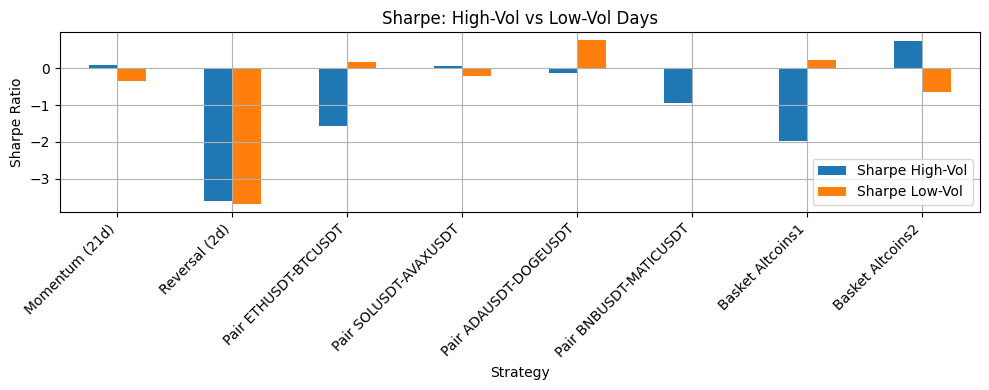

In [23]:
ax = regime_df.plot(kind='bar', title='Sharpe: High-Vol vs Low-Vol Days')
ax.set_ylabel('Sharpe Ratio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---
Test momentum at the **theme** level by grouping coins into logical buckets (e.g., Layer-1s, DeFi).  

Individual Theme Momentum – Long-Only (21-day look-back, 5 bps cost)


,AnnReturn,AnnVol,Sharpe,MaxDrawdown,Alpha,Beta,Alpha t-stat,Beta t-stat
Layer1,-0.09686,0.4307,-0.22489,0.955276,-0.000566,0.425065,-1.045786,21.941453


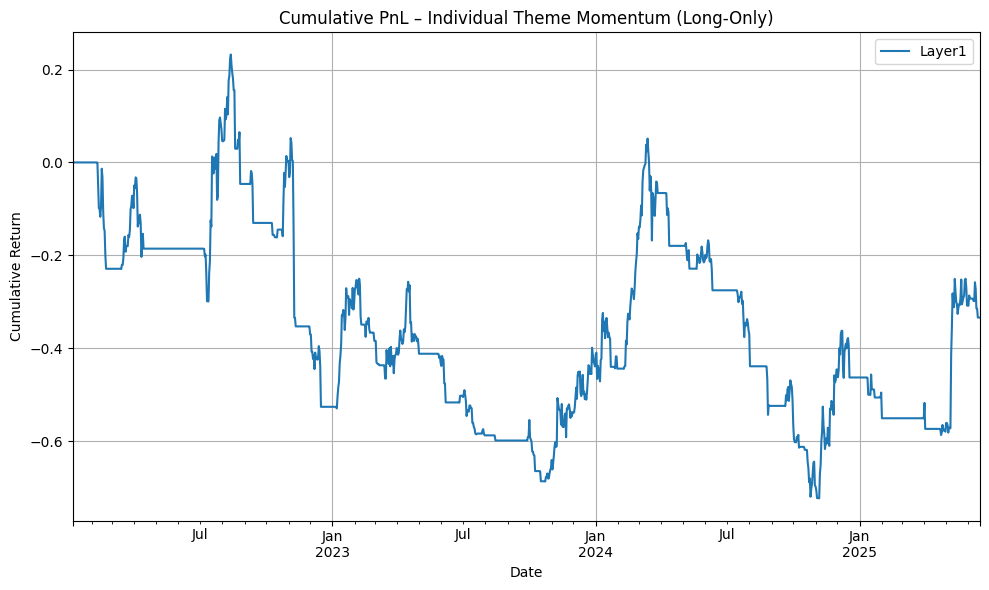

In [24]:
# --- Individual Theme Momentum: full self-contained block ------------------
# --------------------------------------------------------------------------
# 1) THEMES and THEME_PRICES
# --------------------------------------------------------------------------
themes = {
    'Layer1':    ['ETHUSDT','BNBUSDT','SOLUSDT','AVAXUSDT','DOTUSDT','ADAUSDT'],
    'DeFi':      ['UNIUSDT','AAVEUSDT','COMPUSDT','SNXUSDT'],
    'NFT':       ['MANAUSDT','SANDUSDT','AXSUSDT'],
    'Memecoins': ['DOGEUSDT','SHIBUSDT','PEPEUSDT'],
}

# keep only symbols we actually have in prices
themes = {name: [s for s in syms if s in prices.columns] 
          for name, syms in themes.items() if len([s for s in syms if s in prices.columns]) >= 2}

# Build equal-weight theme price series
theme_prices = pd.DataFrame({
    name: prices[syms].mean(axis=1) for name, syms in themes.items()
}).dropna(how='any')

# Theme log-returns
theme_rets = np.log(theme_prices / theme_prices.shift(1)).dropna()

# --------------------------------------------------------------------------
# 2) LONG-ONLY MOMENTUM BACK-TEST
# --------------------------------------------------------------------------
def long_only_backtest(signal: pd.Series, ret: pd.Series, cost_bps: float = 5):
    """
    Simple long-only back-tester: hold 1 when `signal` == 1, else 0.
    Signal and ret must have the same index.
    """
    pos = signal.shift(1).fillna(0)          # enter at next bar
    pnl = pos * ret
    turnover = signal.diff().abs()           # 0→1 or 1→0
    pnl -= turnover * cost_bps / 1e4
    return pnl

lookback = 21
# raw 21-day momentum (sum of returns)
raw_mom = theme_rets.rolling(lookback).sum()

# z-score of raw momentum PER THEME (column-wise)
mom_z = (raw_mom - raw_mom.mean()) / raw_mom.std()

theme_pnls = {}
for theme in mom_z.columns:
    sig = (mom_z[theme] > 0).astype(int)            # long when z > 0
    theme_pnls[theme] = long_only_backtest(sig, theme_rets[theme])

# --------------------------------------------------------------------------
# 3) PERFORMANCE TABLE
# --------------------------------------------------------------------------
rows = []
for theme, pnl in theme_pnls.items():
    ann_ret = pnl.mean() * 365
    ann_vol = pnl.std()  * np.sqrt(365)
    sharpe  = ann_ret / ann_vol if ann_vol else np.nan
    max_dd  = (pnl.cumsum().cummax() - pnl.cumsum()).max()
    
    # alpha / beta vs BTC
    df_reg = pd.DataFrame({'pnl': pnl, 'btc_ret': rets['BTCUSDT']}).dropna()
    mdl    = sm.OLS(df_reg['pnl'], sm.add_constant(df_reg['btc_ret'])).fit()
    
    rows.append(pd.Series({
        'AnnReturn':   ann_ret,
        'AnnVol':      ann_vol,
        'Sharpe':      sharpe,
        'MaxDrawdown': max_dd,
        'Alpha':       mdl.params['const'],
        'Beta':        mdl.params['btc_ret'],
        'Alpha t-stat':mdl.tvalues['const'],
        'Beta t-stat': mdl.tvalues['btc_ret']
    }, name=theme))

theme_perf = pd.DataFrame(rows)
print("Individual Theme Momentum – Long-Only (21-day look-back, 5 bps cost)")
display(theme_perf)

# --------------------------------------------------------------------------
# 4) CUMULATIVE PnL PLOT
# --------------------------------------------------------------------------
plt.figure(figsize=(10,6))
for theme, pnl in theme_pnls.items():
    pnl.cumsum().plot(label=theme)
plt.title('Cumulative PnL – Individual Theme Momentum (Long-Only)')
plt.xlabel('Date'); plt.ylabel('Cumulative Return')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


### Intraday Technical Play: Front-Run Volume Spikes

,AnnReturn,AnnVol,Sharpe,MaxDrawdown,Alpha,Beta
BTCUSDT,0.081890,0.211117,0.387888,0.538040,0.000284,0.106337
ETHUSDT,0.251961,0.256897,0.980786,0.343477,0.000941,0.130978
BNBUSDT,-0.021384,0.239351,-0.089341,0.507287,0.000068,0.036291
SOLUSDT,-0.080433,0.394790,-0.203737,0.729657,-0.000229,0.125107
XRPUSDT,0.209992,0.310463,0.676382,0.333131,0.000172,0.047643
DOGEUSDT,-0.164627,0.464534,-0.354393,1.751372,-0.000168,0.135045
SHIBUSDT,-0.086170,0.384460,-0.224133,0.869775,-0.000313,0.103540
PEPEUSDT,0.704745,0.455651,1.546676,0.207030,0.001862,0.209652


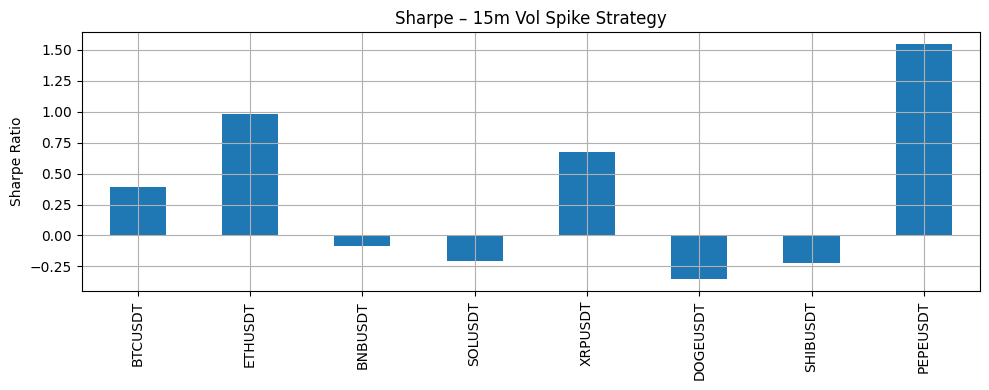

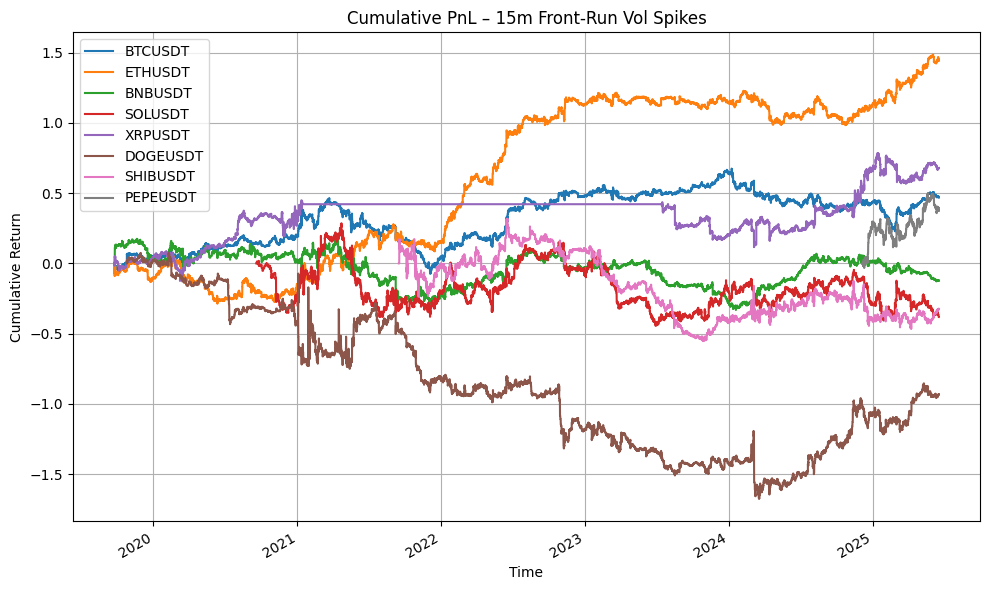

In [25]:
# 1) Define symbols and parameters
symbols = ['BTCUSDT','ETHUSDT','BNBUSDT','SOLUSDT','XRPUSDT','DOGEUSDT','SHIBUSDT','PEPEUSDT']
days_back = 30
lookback_bars = 24  # for 90th percentile (~6 hours)
metrics = {}
pnl_series = {}

# 2) Loop through each symbol
for sym in symbols:
    # fetch 15-min OHLCV
    start = (pd.Timestamp.utcnow() - pd.Timedelta(days=days_back)).strftime("%d %b %Y %H:%M:%S")
    df = get_px(sym, interval='15m', start=0)
    
    # volume spike detection
    df['q90'] = df['vol'].rolling(lookback_bars).quantile(0.9)
    df['spike'] = df['vol'] > df['q90']
    
    # work hours mask (13–21 UTC)
    df['hour'] = df.index.hour
    df['is_work'] = df['hour'].between(13, 21)
    
    # signal: next bar after spike during work hours, flat at UTC midnight
    df['signal'] = (df['spike'] & df['is_work']).shift(1).fillna(0).astype(int)
    df['date'] = df.index.date
    df['signal'] = np.where(df['date'] != df['date'].shift(-1), 0, df['signal'])
    
    # compute 15-min log returns
    df['ret15'] = np.log(df['close'] / df['close'].shift(1))
    
    # long-only backtest
    df['pos'] = df['signal'].shift(1).fillna(0)
    df['pnl'] = df['pos'] * df['ret15']
    pnl = df['pnl'].dropna()
    pnl_series[sym] = pnl.cumsum()
    
    # performance metrics
    bars_per_year = 365 * 24 * 4
    ann_ret = pnl.mean() * bars_per_year
    ann_vol = pnl.std() * np.sqrt(bars_per_year)
    sharpe  = ann_ret / ann_vol if ann_vol else np.nan
    maxdd   = (pnl.cumsum().cummax() - pnl.cumsum()).max()
    
    # daily regression vs BTC
    pnl_daily = pnl.resample('D').sum()
    btc_daily = rets['BTCUSDT'].resample('D').sum()
    df_reg = pd.concat([pnl_daily, btc_daily], axis=1, keys=['pnl','btc_ret']).dropna()
    model = sm.OLS(df_reg['pnl'], sm.add_constant(df_reg['btc_ret'])).fit()
    
    metrics[sym] = {
        'AnnReturn':   ann_ret,
        'AnnVol':      ann_vol,
        'Sharpe':      sharpe,
        'MaxDrawdown': maxdd,
        'Alpha':       model.params['const'],
        'Beta':        model.params['btc_ret']
    }

# 3) Display metrics
metrics_df = pd.DataFrame(metrics).T
display(metrics_df)

# 4) Plot Sharpe ratios
metrics_df['Sharpe'].plot(kind='bar', title='Sharpe – 15m Vol Spike Strategy')
plt.ylabel('Sharpe Ratio')
plt.tight_layout()
plt.show()

# 5) Overlay cumulative PnL
plt.figure(figsize=(10,6))
for sym, pnl_cum in pnl_series.items():
    pnl_cum.plot(label=sym)
plt.title('Cumulative PnL – 15m Front-Run Vol Spikes')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Processing BTCUSDT...
Processing ETHUSDT...
Processing BNBUSDT...
Processing SOLUSDT...
Processing XRPUSDT...
Processing DOGEUSDT...
Processing SHIBUSDT...
Processing PEPEUSDT...


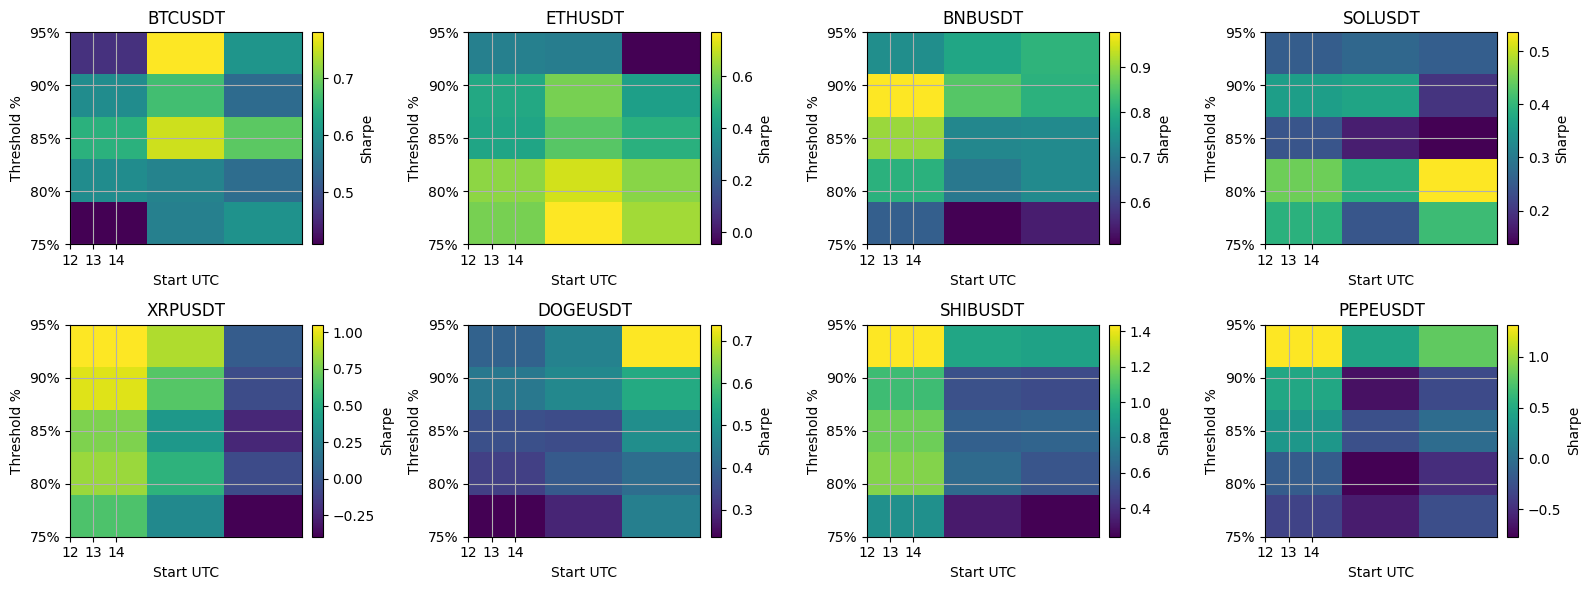

In [26]:
# --- Parameter Sweep Across Multiple Symbols: Intraday Technical Play ---
symbols = ['BTCUSDT','ETHUSDT','BNBUSDT','SOLUSDT',
           'XRPUSDT','DOGEUSDT','SHIBUSDT','PEPEUSDT']
days_back = 360
lookback_bars = 24
thresholds = [0.75, 0.80, 0.85, 0.90, 0.95]
start_hours = [12, 13, 14]

# Container for heatmaps per symbol
heatmaps = {}

for sym in symbols:
    print(f"Processing {sym}...")
    # Fetch 15-min data
    start = (pd.Timestamp.utcnow() - pd.Timedelta(days=days_back)).strftime("%d %b %Y %H:%M:%S")
    df = get_px(sym, interval='15m', start=0)
    df = df[['close','vol']].dropna(how='any')
    df['ret15'] = np.log(df['close'] / df['close'].shift(1))
    
    # Pre-allocate results DataFrame
    res = pd.DataFrame(index=thresholds, columns=start_hours, dtype=float)
    
    for q in thresholds:
        # compute rolling quantile for this threshold
        df['qth'] = df['vol'].rolling(lookback_bars).quantile(q)
        for start in start_hours:
            end = start + 8
            # build signal
            hour = df.index.hour
            sig = ((df['vol'] > df['qth']) & (hour >= start) & (hour < end)).shift(1).fillna(0).astype(int)
            # reset at midnight
            dates = df.index.date
            sig = np.where(dates != np.roll(dates, -1), 0, sig)
            # compute pnl
            pnl = sig * df['ret15']
            pnl = pnl.dropna()
            # annualized Sharpe
            bars_per_year = 365 * 24 * 4
            ann_ret = pnl.mean() * bars_per_year
            ann_vol = pnl.std() * np.sqrt(bars_per_year)
            sharpe = ann_ret / ann_vol if ann_vol else np.nan
            res.loc[q, start] = sharpe
    
    heatmaps[sym] = res

# Plot heatmaps
n = len(symbols)
cols = 4
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), squeeze=False)

for idx, sym in enumerate(symbols):
    r = idx // cols
    c = idx % cols
    ax = axes[r][c]
    hm = heatmaps[sym].values.astype(float)
    im = ax.imshow(hm, origin='lower', aspect='auto',
                   extent=[min(start_hours), max(start_hours)+8,
                           min(thresholds)*100, max(thresholds)*100])
    ax.set_title(sym)
    ax.set_xlabel('Start UTC')
    ax.set_ylabel('Threshold %')
    ax.set_xticks(start_hours)
    ax.set_yticks([t*100 for t in thresholds])
    ax.set_yticklabels([f"{int(t*100)}%" for t in thresholds])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Sharpe')

# Hide empty subplots
for j in range(idx+1, rows*cols):
    fig.delaxes(axes[j//cols][j%cols])

fig.tight_layout()
plt.show()


---
## Execution Cost Comparison: Market vs. Limit Orders

We’ll re-run two of our flagship strategies—daily 21-day momentum and the 15-min intraday spike play—under two execution cost regimes:

- **Market orders**: 20 bps total round-trip cost  
- **Limit orders**: 7 bps commission, zero slippage  

We’ll compare their net PnL, turnover, and key stats side-by-side.

AnnReturn    AnnVol     Sharpe  MaxDrawdown
Symbol   Order                                              
BTCUSDT  Market  -5.645415  0.141062 -40.020857     0.473953
         Limit   -1.978691  0.105907 -18.683273     0.174669
ETHUSDT  Market  -5.097619  0.203977 -24.991086     0.422910
         Limit   -1.368215  0.184081  -7.432675     0.150389
BNBUSDT  Market  -6.377613  0.136988 -46.555835     0.529314
         Limit   -2.616870  0.091476 -28.607313     0.218614
SOLUSDT  Market  -7.288895  0.260700 -27.958959     0.607132
         Limit   -3.308775  0.235878 -14.027480     0.280832
XRPUSDT  Market  -5.393293  0.163558 -32.974834     0.448724
         Limit   -1.883266  0.136332 -13.813781     0.171741
DOGEUSDT Market  -5.847195  0.241377 -24.224368     0.488407
         Limit   -2.525205  0.223832 -11.281690     0.215407
SHIBUSDT Market  -5.035340  0.206963 -24.329690     0.418682
         Limit   -1.243258  0.184994  -6.720512     0.109167
PEPEUSDT Market  -6.361304  0.366434 -17.360020     0.548783
         Limit   -2.945296  0.350731  -8.397596     0.270583

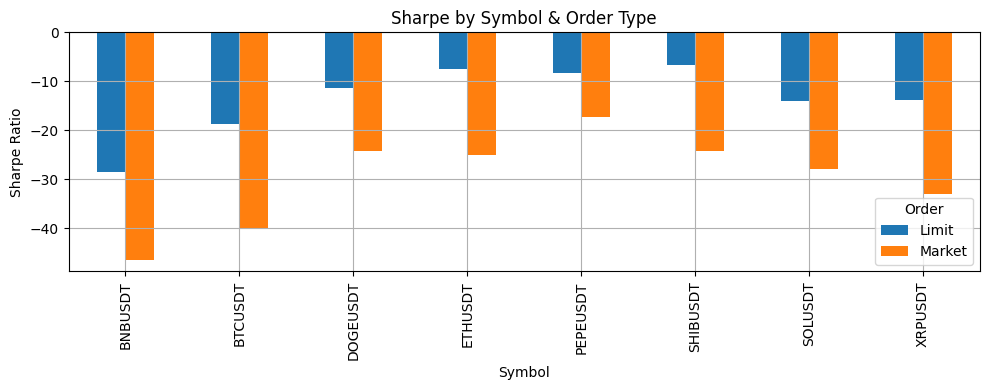

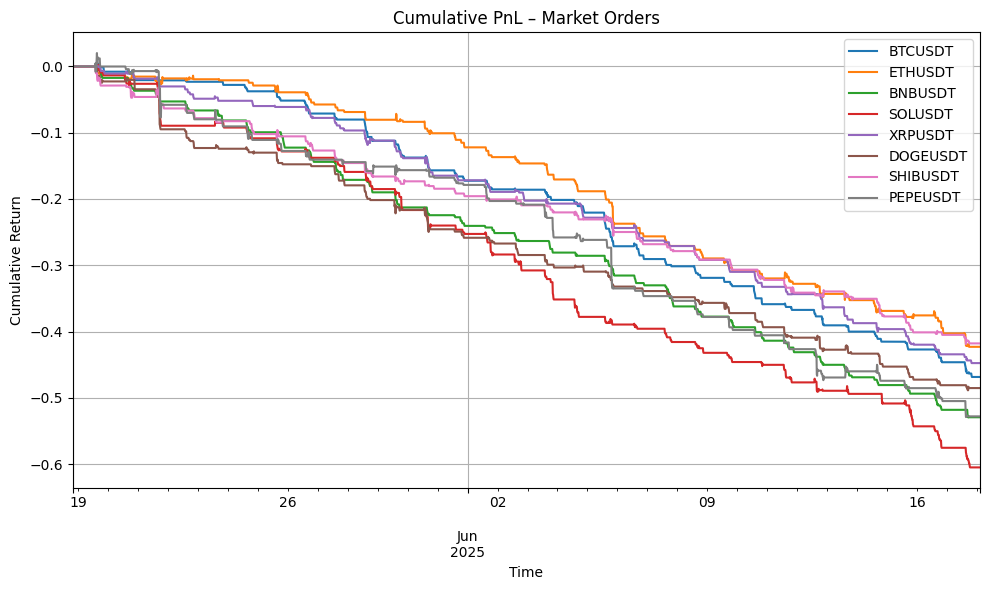

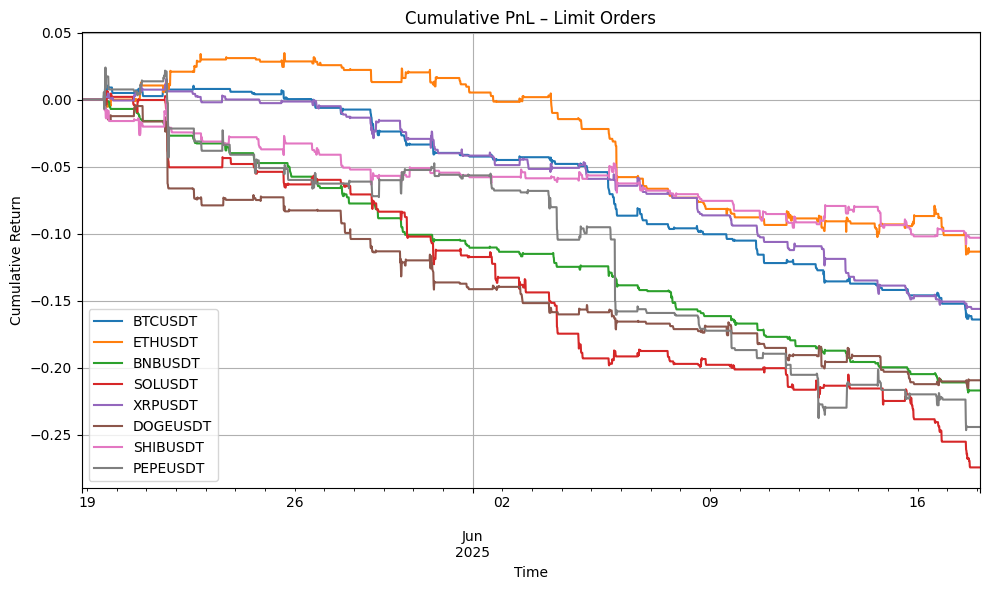

In [27]:
# 1) Define symbols and parameters
symbols = ['BTCUSDT','ETHUSDT','BNBUSDT','SOLUSDT',
           'XRPUSDT','DOGEUSDT','SHIBUSDT','PEPEUSDT']
lookback_bars = 24  # for 6-hour volume spikes

# 2) Containers for metrics and PnL
metrics = []
pnl_data = {}
start_time = datetime.now() - timedelta(days=30)

# 3) Loop over each symbol
for sym in symbols:
    # fetch data
    df = get_px(sym, interval='15m', start=str(start_time)).dropna()
    df['ret15'] = np.log(df['close'] / df['close'].shift(1))
    # compute spike
    df['q90'] = df['vol'].rolling(lookback_bars).quantile(0.9)
    df['spike'] = df['vol'] > df['q90']
    # work-hour mask
    hr = df.index.hour
    work = (hr >= 13) & (hr < 21)
    # signal
    df['signal'] = (df['spike'] & work).shift(1).fillna(0).astype(int)
    dates = df.index.date
    df['signal'] = np.where(dates != np.roll(dates, -1), 0, df['signal'])
    # evaluate costs
    for cost_bps, order_type in [(20, 'Market'), (7, 'Limit')]:
        pos = df['signal'].shift(1).fillna(0)
        pnl = pos * df['ret15']
        turn = pos.diff().abs()
        pnl_net = pnl - turn * (cost_bps/1e4)
        # store cumulative series
        pnl_data[(sym, order_type)] = pnl_net.cumsum()
        # metrics
        bars_per_year = 365 * 24 * 4
        ann_ret = pnl_net.mean() * bars_per_year
        ann_vol = pnl_net.std()  * np.sqrt(bars_per_year)
        sharpe  = ann_ret / ann_vol if ann_vol else np.nan
        max_dd  = (pnl_net.cumsum().cummax() - pnl_net.cumsum()).max()
        metrics.append({
            'Symbol': sym,
            'Order': order_type,
            'AnnReturn': ann_ret,
            'AnnVol': ann_vol,
            'Sharpe': sharpe,
            'MaxDrawdown': max_dd
        })

# 4) Build metrics DataFrame
metrics_df = pd.DataFrame(metrics).set_index(['Symbol','Order'])
display(metrics_df)

# 5) Bar chart of Sharpe ratios
metrics_df['Sharpe'].unstack().plot(kind='bar', title='Sharpe by Symbol & Order Type')
plt.ylabel('Sharpe Ratio')
plt.tight_layout()
plt.show()

# 6) Overlay cumulative PnL curves (Market orders)
plt.figure(figsize=(10,6))
for sym in symbols:
    pnl_data[(sym,'Market')].plot(label=sym)
plt.title('Cumulative PnL – Market Orders')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7) Overlay cumulative PnL curves (Limit orders)
plt.figure(figsize=(10,6))
for sym in symbols:
    pnl_data[(sym,'Limit')].plot(label=sym)
plt.title('Cumulative PnL – Limit Orders')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### ───────────────────────── MACRO REGIME REVERSAL STUDY ─────────────────────────
#####
##### Tests whether short-horizon reversal works better during “turbulent / dislocated”
##### crypto markets, measured via:
#####   • Realized volatility of BTC   (21-day std)
#####   • Cross-section return dispersion
#####   • Average pairwise correlation (21-day window)
#####   • Optional: Implied volatility series `impl_vol`
#####
##### For each coin and each look-back window, we compute reversal PnL and compare
##### Sharpe in High vs Low macro regimes (split at median of each indicator).
##### A grid of bar-charts is produced for every coin × indicator × look-back combo.
##### ───────────────────────────────────────────────────────────────────────────────

Fetching missing coins: SHIBUSDT, PEPEUSDT
  ✓ SHIBUSDT added
  ✓ PEPEUSDT added
Sharpe by Symbol × Lookback × Indicator (High vs Low)


Regime                            High       Low
Symbol  Lookback Indicator                      
BNBUSDT 1        AvgPairCorr -1.664356  2.247439
                 Dispersion  -1.886742  3.385553
                 RealizedVol  2.028911 -1.792003
        2        AvgPairCorr  1.947905  2.002127
                 Dispersion   1.174136  3.471329
...                                ...       ...
XRPUSDT 3        Dispersion   3.279331 -0.002620
                 RealizedVol  2.510123  0.716998
        5        AvgPairCorr  3.493182 -0.762661
                 Dispersion   2.441371  0.574610
                 RealizedVol  1.820693  1.816561

[96 rows x 2 columns]

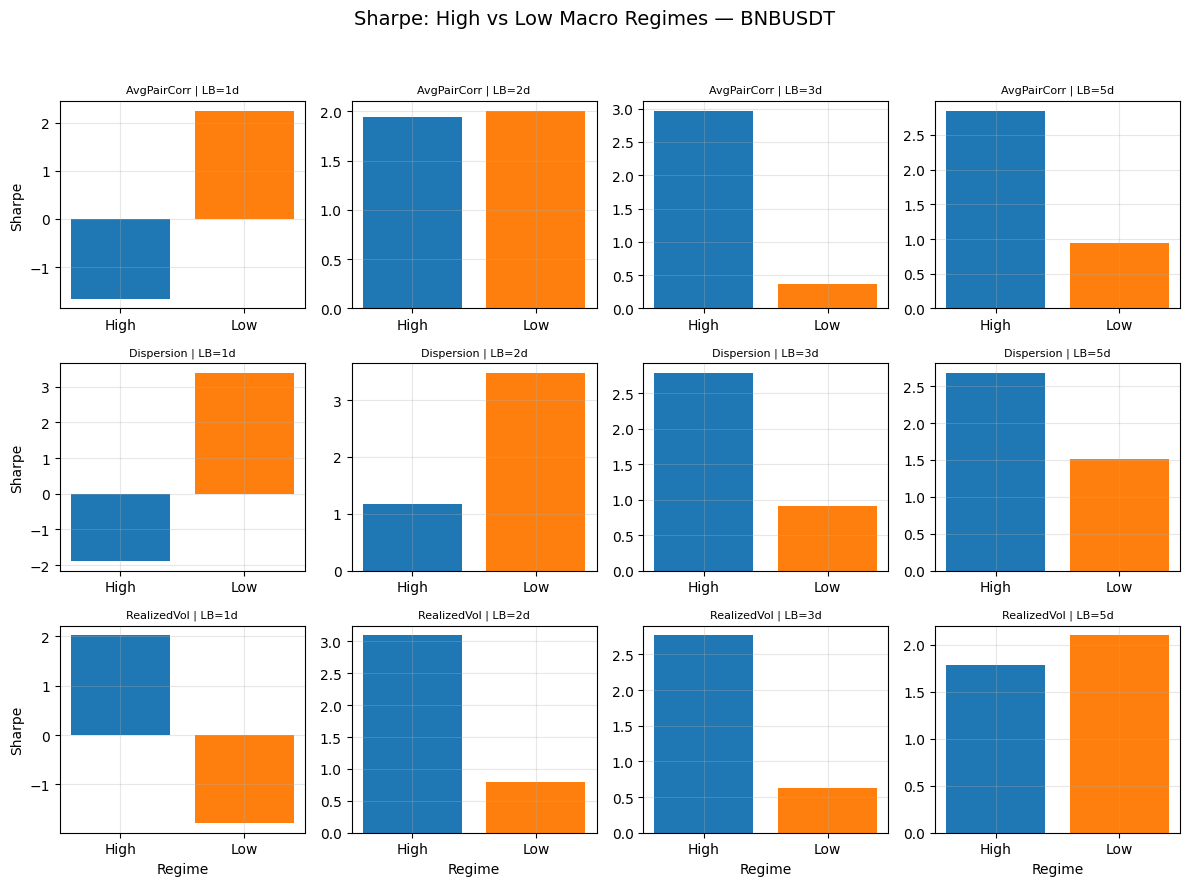

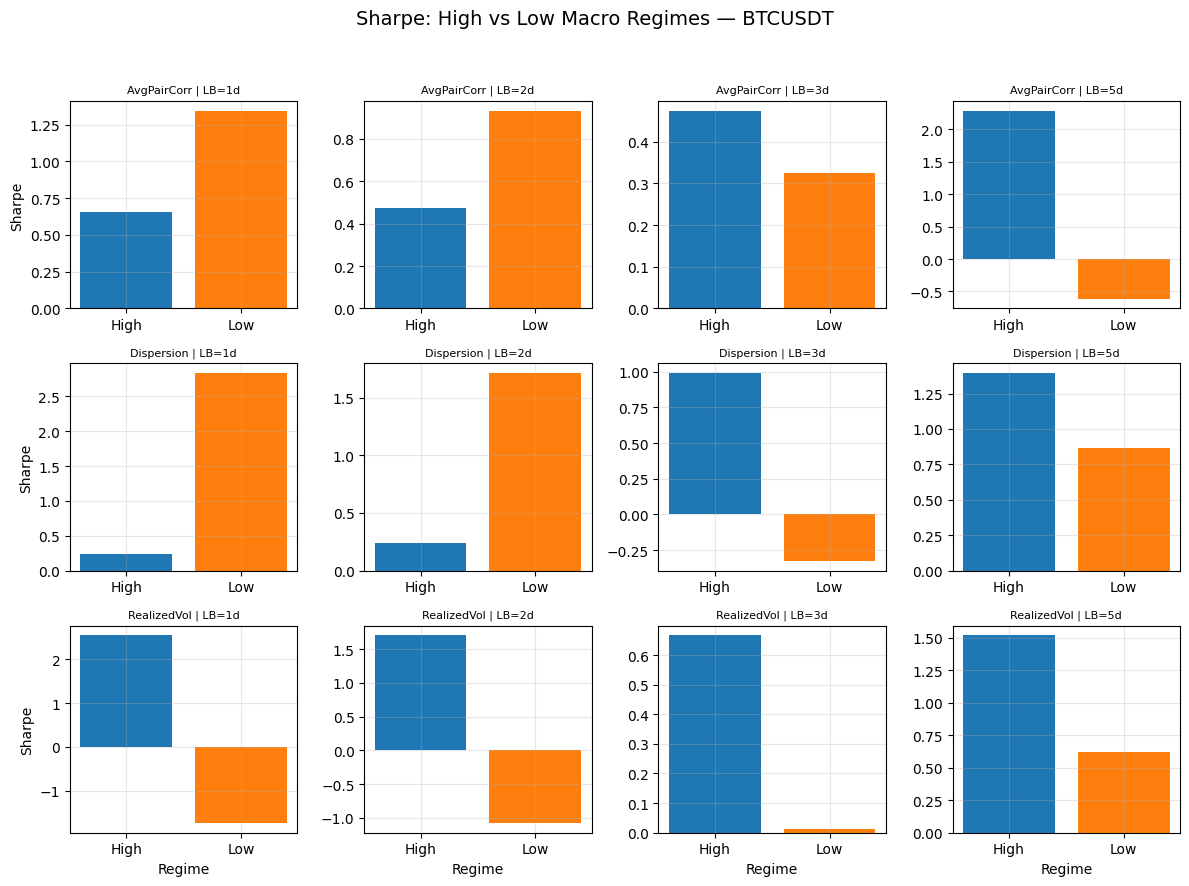

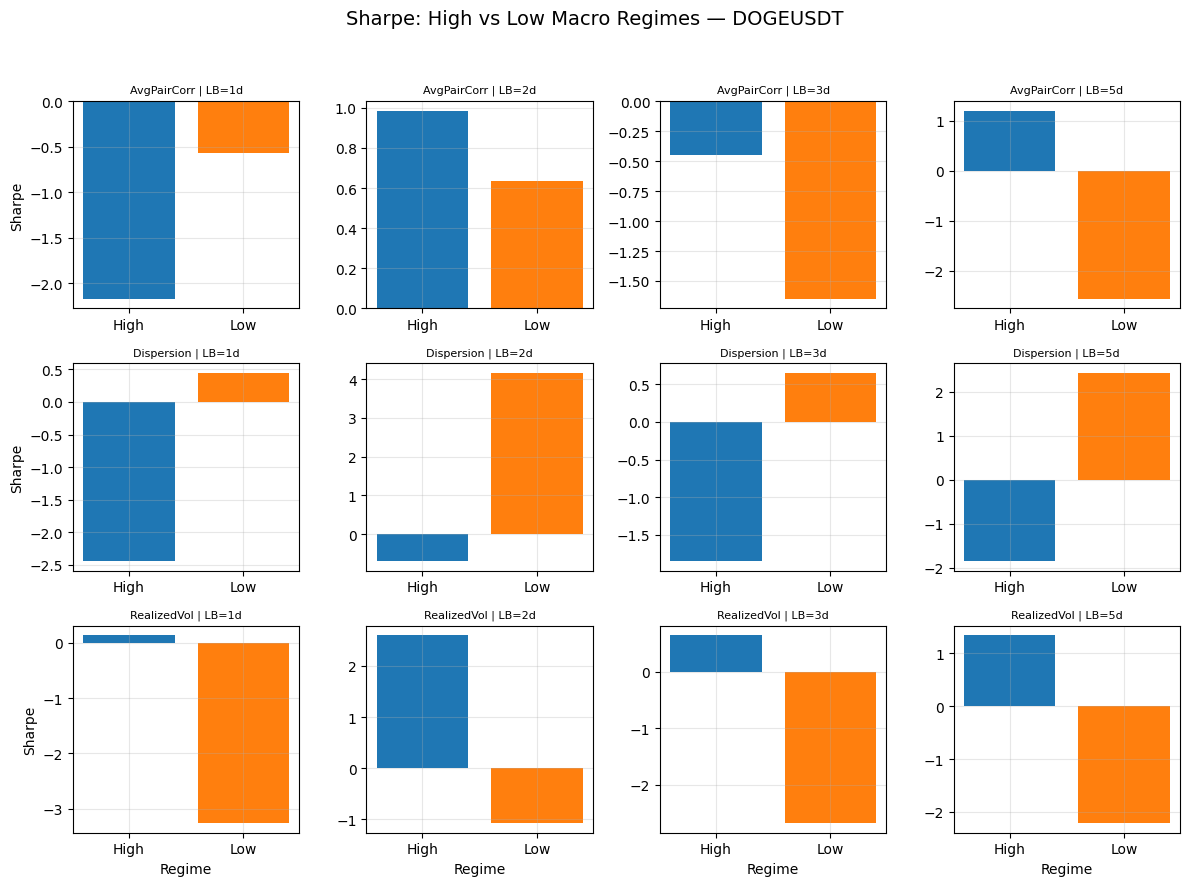

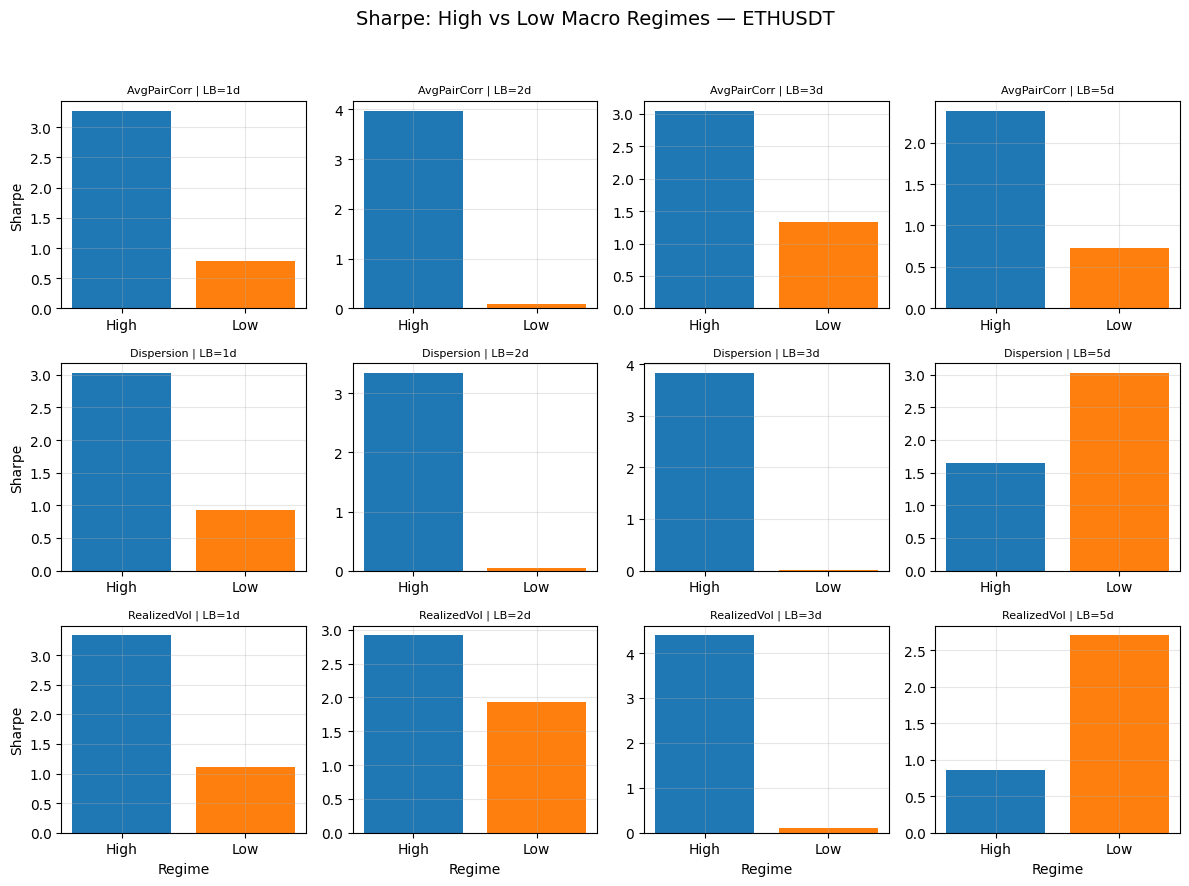

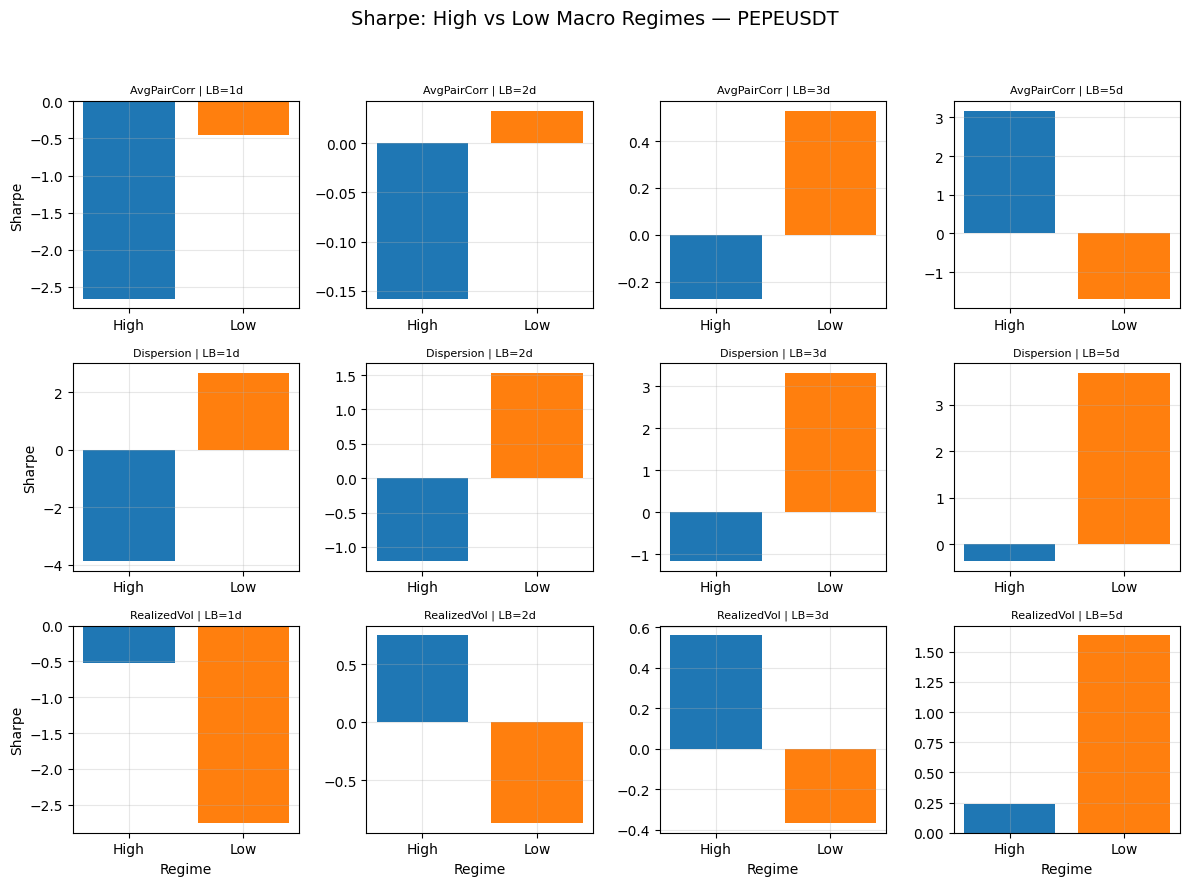

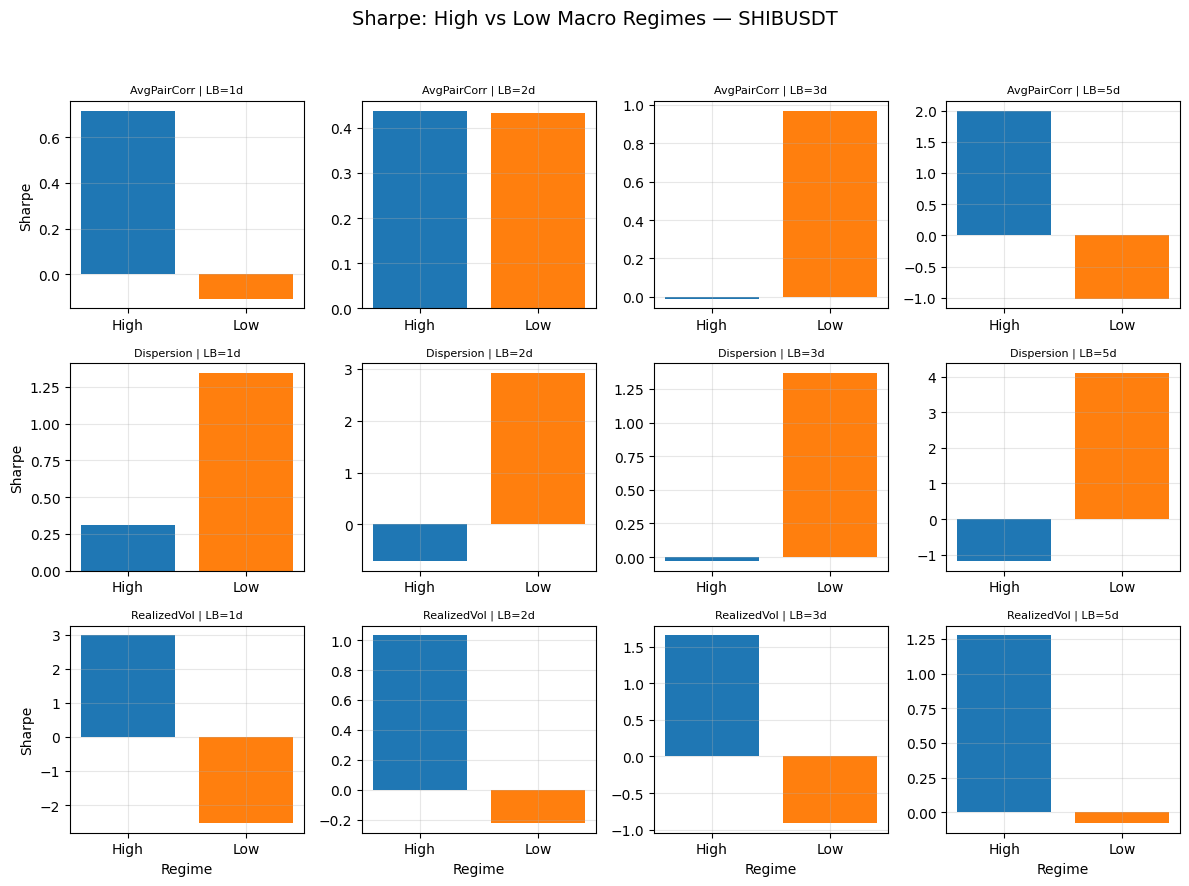

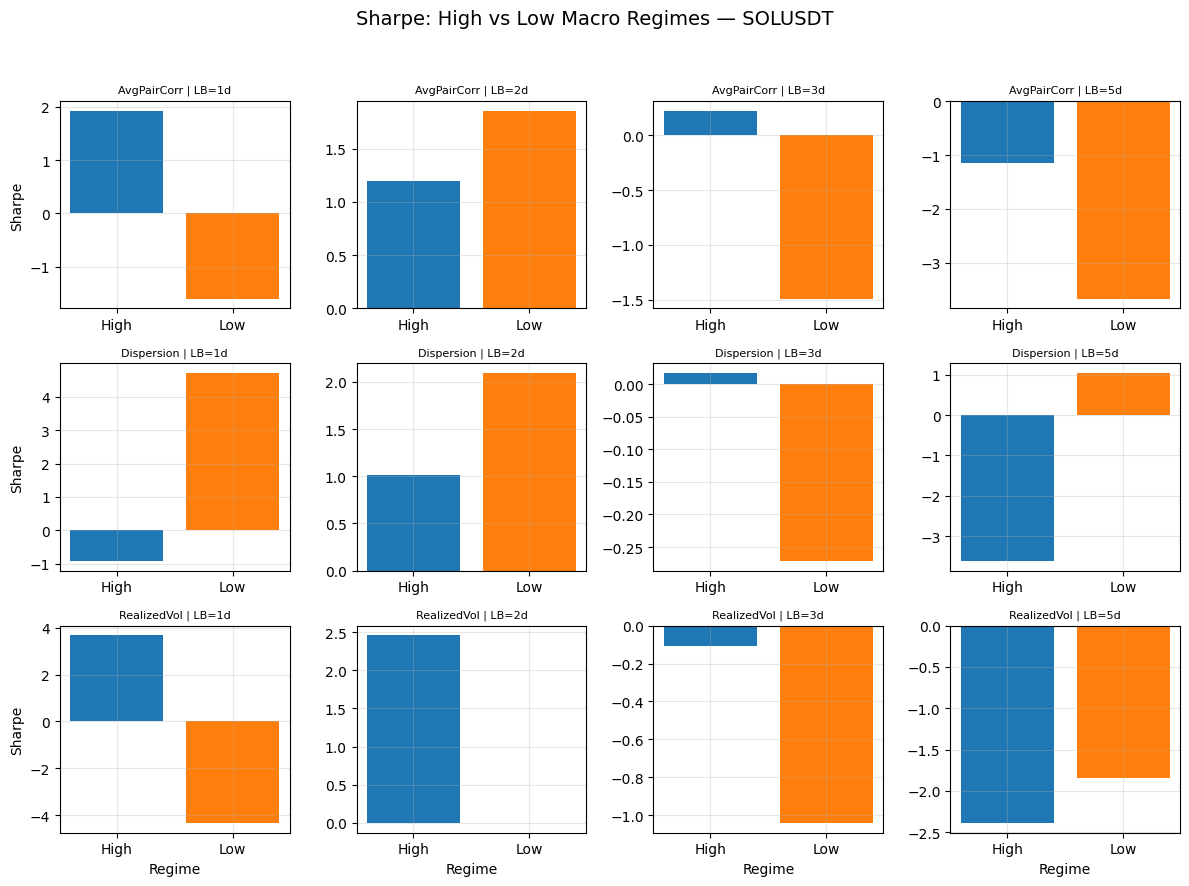

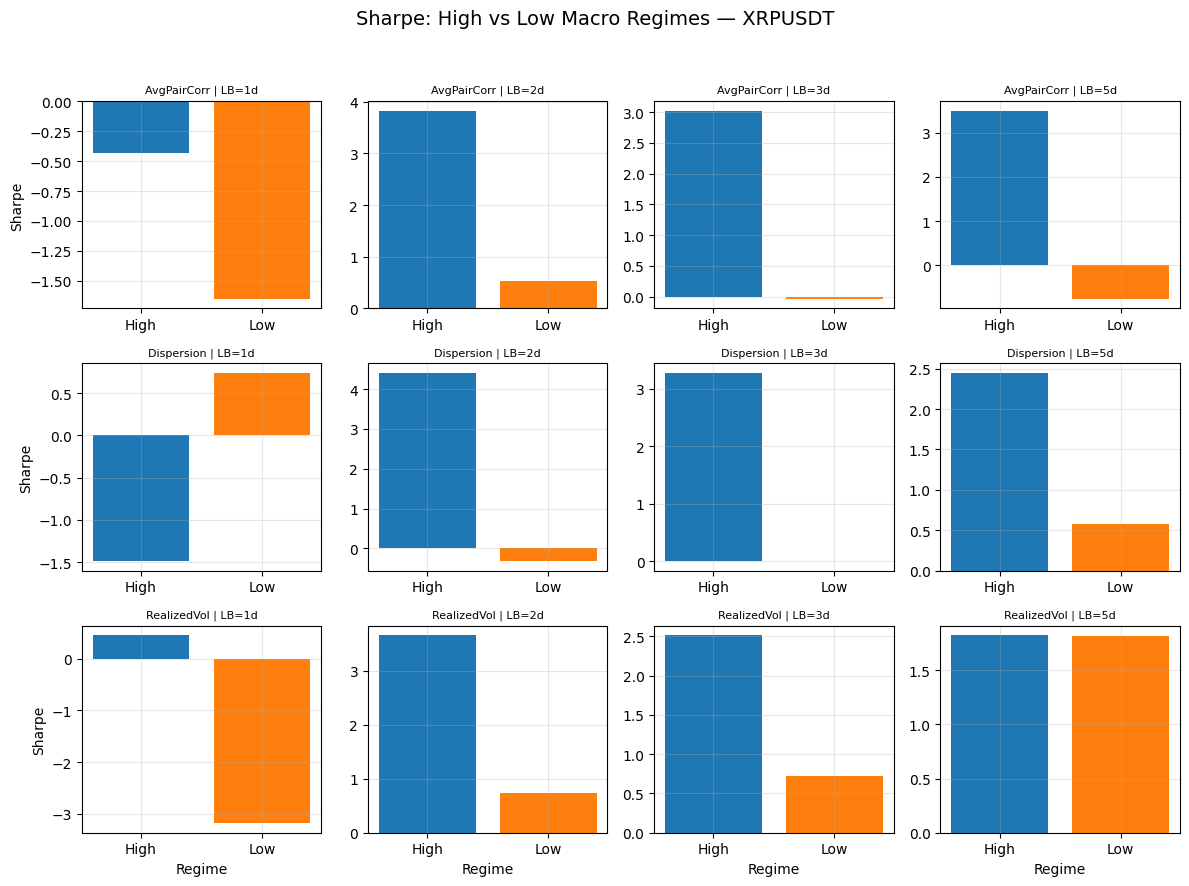

In [28]:
# 0) Universe & parameters
symbols = ['BTCUSDT','ETHUSDT','BNBUSDT','SOLUSDT',
           'XRPUSDT','DOGEUSDT','SHIBUSDT','PEPEUSDT']
lookbacks = [1, 2, 3, 5]
window = 21                 # macro look-back (21d)

# 1) Ensure every symbol is in prices / rets  -------------------------------
missing = [s for s in symbols if s not in prices.columns]
if missing:
    print("Fetching missing coins:", ", ".join(missing))
    for sym in missing:
        try:
            df_px = get_px(sym, interval='1d', start='1 Jan 2020')
            prices[sym] = df_px['close']
            print(f"  ✓ {sym} added")
        except Exception as e:
            print(f"  ✗ {sym} failed → {e}")

# rebuild returns
prices = prices.sort_index().ffill()
rets   = np.log(prices / prices.shift(1)).dropna()

# drop any still-missing tickers from symbols
symbols = [s for s in symbols if s in rets.columns]

# 2) Macro indicators ------------------------------------------------------
real_vol   = rets['BTCUSDT'].rolling(window).std()
dispersion = rets[symbols].std(axis=1)

# average pairwise corr (21-day)
avg_pair_corr = pd.Series(index=rets.index, dtype=float)
n = len(symbols)
for i in range(window-1, len(rets)):
    mat = rets[symbols].iloc[i-window+1:i+1].corr().values
    avg_pair_corr.iloc[i] = mat[np.triu_indices(n, k=1)].mean()

indicators = {
    'RealizedVol':  real_vol,
    'Dispersion':   dispersion,
    'AvgPairCorr':  avg_pair_corr
}
# ── optional implied vol series named impl_vol ──
if 'impl_vol' in globals():
    indicators['ImpliedVol'] = impl_vol.reindex(rets.index)

# 3) Reversal PnL helper ---------------------------------------------------
def reversal_pnl(series: pd.Series, lb: int) -> pd.Series:
    signal = -series.rolling(lb).sum().shift(1)
    pos    = np.sign(signal)
    return (pos * series).dropna()

# 4) Loop & collect stats --------------------------------------------------
rows = []
for sym in symbols:
    for lb in lookbacks:
        pnl = reversal_pnl(rets[sym], lb)
        for ind_name, ind in indicators.items():
            ind = ind.reindex(pnl.index).dropna()
            med = ind.median()
            hi_idx = ind[ind >  med].index
            lo_idx = ind[ind <= med].index
            for regime, idx in [('High', hi_idx), ('Low', lo_idx)]:
                sub = pnl.reindex(idx).dropna()
                ann = sub.mean()*365
                vol = sub.std() * np.sqrt(365)
                sharpe = ann/vol if vol else np.nan
                mdd = (sub.cumsum().cummax() - sub.cumsum()).max()
                rows.append({
                    'Symbol': sym, 'Lookback': lb,
                    'Indicator': ind_name, 'Regime': regime,
                    'Sharpe': sharpe, 'AnnRet': ann, 'MaxDD': mdd
                })

df_macro = pd.DataFrame(rows)

# 5) Summary pivot ---------------------------------------------------------
print("Sharpe by Symbol × Lookback × Indicator (High vs Low)")
pivot = df_macro.pivot_table(
    index=['Symbol','Lookback','Indicator'],
    columns='Regime', values='Sharpe'
)
display(pivot)

# 6) Grid of bar-charts ----------------------------------------------------
syms = sorted(df_macro.Symbol.unique())
lbs  = sorted(df_macro.Lookback.unique())
inds = sorted(df_macro.Indicator.unique())

for sym in syms:
    fig, axes = plt.subplots(len(inds), len(lbs),
                             figsize=(3*len(lbs), 3*len(inds)),
                             squeeze=False)
    fig.suptitle(f'Sharpe: High vs Low Macro Regimes — {sym}', fontsize=14)
    for i, ind in enumerate(inds):
        for j, lb in enumerate(lbs):
            ax = axes[i][j]
            sub = df_macro[(df_macro.Symbol==sym)&
                           (df_macro.Lookback==lb)&
                           (df_macro.Indicator==ind)]
            sub = sub.set_index('Regime').reindex(['High','Low'])
            ax.bar(sub.index, sub.Sharpe,
                   color=['tab:blue','tab:orange'])
            ax.set_title(f'{ind} | LB={lb}d', fontsize=8)
            ax.grid(True, alpha=0.3)
            if i==len(inds)-1: ax.set_xlabel('Regime')
            if j==0:           ax.set_ylabel('Sharpe')
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

##### ─────────── Strategy Weighting & Portfolio Blend ────────────

 Auto-discovers all Series named like '*pnl*' in globals(), builds a combined DataFrame `strat_pnls`, then blends via:
   - Equal notional
   - Sharpe-weighted
   - Equal-risk-contribution
   - Inverse-vol (63-day σ)

 All portfolios are scaled to 10 % target annualised vol.

Strategies used: ['Mom21', 'Rev2']


,AnnRet,AnnVol,Sharpe,MaxDD
Equal,-31.59%,10.00%,-315.86%,110.72%
Sharpe-Weighted,-0.53%,10.00%,-5.33%,26.32%
Risk-Parity,-31.90%,10.00%,-319.03%,111.78%
Inverse-Vol,-33.30%,10.00%,-332.99%,116.45%



Sharpe-weighted weights


,Weight
Mom21,100.00%
Rev2,0.00%



Risk-Parity weights


,Weight
Mom21,49.48%
Rev2,50.52%


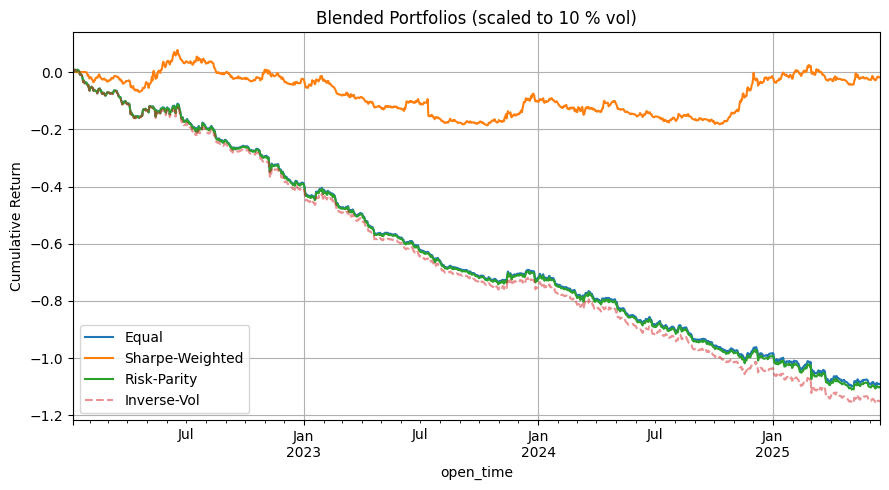

In [29]:
strategy_pnls = {
    'Mom21' : pnl_mom21,                            # <-- replace with your var
    'Rev2'  : pnl_rev2,
    # 'Spike' : pnl_intraday.resample('D').sum(),     # intraday → daily
    # 'Pair'  : pnl_pair,                           # add / remove as needed
}
strat_pnls = pd.concat(strategy_pnls, axis=1).dropna()
print("Strategies used:", list(strat_pnls.columns))

# 1) ------------------------------------------------ helpers
def perf(x):
    ann_r = x.mean()*365
    ann_v = x.std()*np.sqrt(365)
    return pd.Series({'AnnRet':ann_r, 'AnnVol':ann_v,
                      'Sharpe':ann_r/ann_v if ann_v else np.nan,
                      'MaxDD': (x.cumsum().cummax()-x.cumsum()).max()})

def scale(x, target=0.10):
    v = x.std()*np.sqrt(365);  return x if v==0 else x*target/v

def erc(cov, tol=1e-8, it=500):
    w = np.ones(len(cov))/len(cov)
    for _ in range(it):
        rc = w*(cov@w); diff = rc-rc.mean()
        if np.abs(diff).max()<tol: break
        w -= 0.1*diff/rc.mean(); w=np.clip(w,0,None); w/=w.sum()
    return w

window = min(365, len(strat_pnls))   # shrink window for short history

# 2) ------------------------------------------------ weights & blends
# Equal
w_eq = np.repeat(1/strat_pnls.shape[1], strat_pnls.shape[1])
p_eq = scale(strat_pnls @ w_eq)

# Sharpe-weighted (clip <0)
mu, sig = strat_pnls[-window:].mean(), strat_pnls[-window:].std()
sh_vec  = (mu/sig).clip(lower=0)
w_sh = sh_vec/sh_vec.sum() if sh_vec.sum()>0 else w_eq
p_sh = scale(strat_pnls @ w_sh)

# Risk-parity
cov = strat_pnls[-window:].cov().values
w_rp = erc(cov);  p_rp = scale(strat_pnls @ w_rp)

# Inverse-vol (63-day; fallback to full sample)
sig63 = strat_pnls.rolling(63).std().iloc[-1] if len(strat_pnls)>=63 else strat_pnls.std()
w_iv  = (1/sig63)/(1/sig63).sum();  p_iv = scale(strat_pnls @ w_iv)

# 3) ------------------------------------------------ summary
summary = pd.concat({
    'Equal'          : perf(p_eq),
    'Sharpe-Weighted': perf(p_sh),
    'Risk-Parity'    : perf(p_rp),
    'Inverse-Vol'    : perf(p_iv)
}, axis=1).T
display(summary.style.format("{:.2%}"))

print("\nSharpe-weighted weights")
display(pd.Series(w_sh, index=strat_pnls.columns, name='Weight')
        .to_frame().style.format("{:.2%}"))

print("\nRisk-Parity weights")
display(pd.Series(w_rp, index=strat_pnls.columns, name='Weight')
        .to_frame().style.format("{:.2%}"))

# 4) ------------------------------------------------ plot
plt.figure(figsize=(9,5))
p_eq.cumsum().plot(label='Equal')
p_sh.cumsum().plot(label='Sharpe-Weighted')
p_rp.cumsum().plot(label='Risk-Parity')
p_iv.cumsum().plot(label='Inverse-Vol', ls='--', alpha=0.5)
plt.title('Blended Portfolios (scaled to 10 % vol)')
plt.ylabel('Cumulative Return')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()